In [1]:
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import lxml
from collections import defaultdict
import sys
import collections
import random
%matplotlib inline

In [2]:
train_path = '/media/dk/MyFiles/Data/VOC/VOC2012train/VOCdevkit/VOC2012/Annotations/'

# 数据预处理

## 从xml文件中提取数据

In [3]:
VOC_BBOX_LABEL_NAMES = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
                        'bus', 'car', 'cat', 'chair', 'cow',
                        'diningtable', 'dog', 'horse', 'motorbike', 'person',
                        'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')

In [4]:
def parse_voc2012_xml(xml_file):
    bboxes = []
    labels = []
    obj_names = []
    bs = BeautifulSoup(open(xml_file))
    img_file_name = bs.find('filename').string
    
    size_obj = bs.find('size')
    width = int(float((size_obj.find('width').string)))
    height = int(float((size_obj.find('height').string)))
    
    for obj in bs.find_all('object'):
        diffcult = int(obj.find('difficult').string)
        if diffcult == 1:
            continue
        name = obj.find('name').string
        obj_names.append(name)
        if name in VOC_BBOX_LABEL_NAMES:
            label = VOC_BBOX_LABEL_NAMES.index(name)
            bndbox_obj = obj.find('bndbox', recursive=False)
            y1 = int(float(bndbox_obj.find('ymax').string))
            x1 = int(float(bndbox_obj.find('xmax').string))
            y2 = int(float(bndbox_obj.find('ymin').string))
            x2 = int(float(bndbox_obj.find('xmin').string))
            bboxes.append([y1, x1, y2, x2])
            labels.append(label)

    return img_file_name, bboxes, labels, obj_names, width, height

In [5]:
def parse_voc(train_path):
    AnnotationsPath = train_path
    xml_fils = os.listdir(AnnotationsPath)
    data_list = []
    for f in tqdm(xml_fils):
        tmp_dict = {}
        xml_path = os.path.join(AnnotationsPath, f)
        img_file_name, bboxes, labels, obj_names, width, height = parse_voc2012_xml(xml_path)
        if len(labels) == 0:
#             print(img_file_name)
            continue
            
        tmp_dict['file_name'] = img_file_name
        tmp_dict['obj'] = {'bbox': bboxes, 'label': labels, 'name': obj_names}
        tmp_dict['width'] = width
        tmp_dict['height'] = height
        
        data_list.append(tmp_dict)
    return data_list

In [6]:
data_list = parse_voc(train_path)

100%|██████████| 17125/17125 [00:36<00:00, 465.23it/s]


In [7]:
len(data_list)

17117

In [8]:
data_list[0]

{'file_name': '2010_005023.jpg',
 'obj': {'bbox': [[214, 263, 145, 146]], 'label': [2], 'name': ['bird']},
 'width': 500,
 'height': 333}

## 可视化类别分布

In [9]:
box_label = defaultdict(list)

for img in data_list:
    for name in img['obj']['name']:
        box_label[name].append(1)

In [10]:
barh_y = []
barh_w = []

for k, v in box_label.items():
    barh_y.append(k)
    barh_w.append(sum(v))

sort_index = list(np.argsort(np.array(barh_w)))

print(barh_w)
print(sort_index, type(sort_index))

[1169, 1329, 635, 15753, 672, 753, 1055, 638, 2105, 1266, 902, 2443, 911, 763, 1571, 642, 839, 760, 592, 878]
[18, 2, 7, 15, 4, 5, 17, 13, 16, 19, 10, 12, 6, 0, 9, 1, 14, 8, 11, 3] <class 'list'>


In [11]:
barh_w = np.array(barh_w)
barh_y = np.array(barh_y)

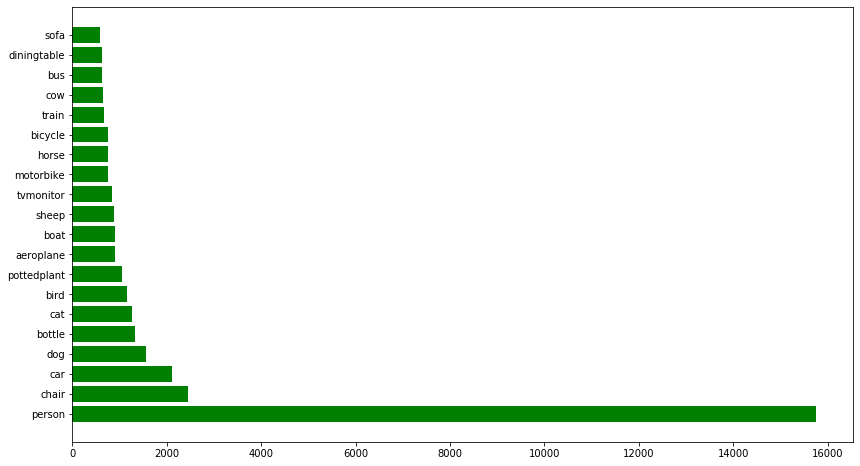

In [12]:
fig = plt.figure(figsize=[14, 8])
ax = fig.add_subplot(111)
ax.barh(y=barh_y[sort_index[::-1]], width=barh_w[sort_index[::-1]], fc='g')
ax.set_yticks(range(len(barh_y)))
plt.show()

## 标准化（归一化）bbox的width和heigth，为kmeans算法的输入做准备

In [13]:
cluster_x = []
cluster_y = []

for img in data_list:
    img_width = img['width']
    img_height = img['height']
    # box: [ymax, xmax, ymin, xmin]
    for box in img['obj']['bbox']:
        box_width = box[1] - box[-1]
        box_height = box[0]  - box[2]
        cluster_x.append(box_width / img_width)
        cluster_y.append(box_height / img_height)
        
print(len(cluster_x))

35676


## 可视化标准化后的bbox分布

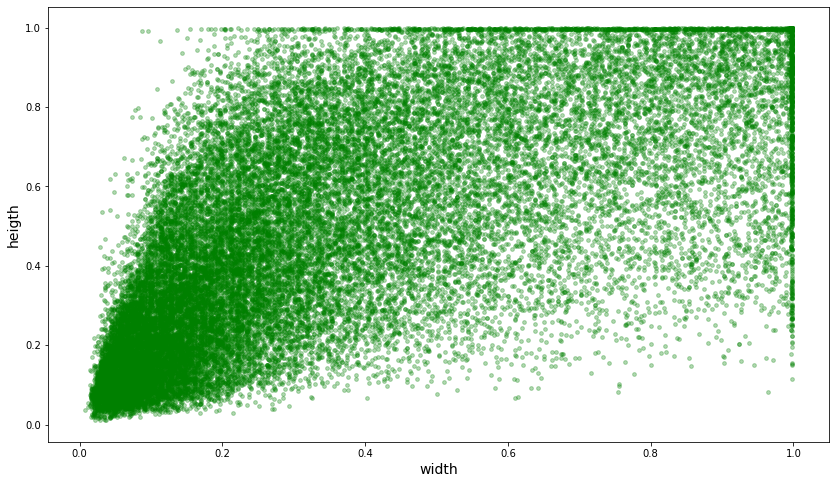

In [14]:
fig = plt.figure(figsize=[14, 8])
ax = fig.add_subplot(111)
ax.scatter(x=cluster_x, y=cluster_y, s=14, alpha = 0.3, c='g')
ax.set_xlabel('width', fontsize=14)
ax.set_ylabel('heigth', fontsize=14)
plt.show()

# 聚类(kmenas/kmeans++)

In [15]:
def iou(center_box, other_boxes):
    intersection_box = np.where(center_box < other_boxes, center_box, other_boxes)
    intersection_area = np.prod(intersection_box, axis=1)
    center_box_area = np.prod(center_box)
    otherbox_areas = np.prod(other_boxes, axis=1)
    ious = intersection_area / (center_box_area + otherbox_areas - intersection_area)
    return ious

In [16]:
# test function iou
bbox1 = np.array([1,1])
bbox2 = np.array([[2,2],[3,3]])
print(iou(bbox1, bbox2))

[0.25       0.11111111]


In [17]:
def alias_setup(probs):
    """
    probs： 某个概率分布
    返回: Alias数组与Prob数组
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int)
    smaller = []
    larger = []
    for i, prob in enumerate(probs):
        q[i] = K * prob  # 概率
        if q[i] < 1.0:
            smaller.append(i)
        else:
            larger.append(i)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] - (1.0 - q[small])

        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def alias_draw(J, q):
    '''
    输入: Prob数组和Alias数组
    输出: 一次采样结果
    '''
    K = len(J)
    k = int(np.floor(np.random.rand() * K))  # 随机取一列
    if np.random.rand() < q[k]:
        return k
    else:
        return J[k]

def alias_sample(probs, samples):
    assert isinstance(samples, int), 'Samples must be a integer.'
    sample_result = []
    J, p = alias_setup(probs)
    for i in range(samples):
        sample_result.append(alias_draw(J, p))
    return sample_result

## kmeans

In [18]:
def classification(k, bboxes, use_alias):
    length = len(bboxes)
    center_index = get_centers(k, bboxes, use_alias)
    center_coord = bboxes[center_index]
    center_tmp = np.zeros_like(center_coord)
    ori_dis = np.full(shape=length, fill_value=np.inf)
    class_list = np.zeros(shape=length) - 1
    
    times = 1
    while np.sum(np.square(center_coord - center_tmp)) > 1e-7:
        times += 1
        center_tmp = center_coord.copy()
        for i in range(k):
            new_dis = 1 - iou(center_coord[i], bboxes)
            class_list = np.where(ori_dis < new_dis, class_list, i)
            ori_dis = np.where(ori_dis < new_dis, ori_dis, new_dis)
        # update center
        for i in range(k):
            center_coord[i] = np.mean(bboxes[class_list == i], axis=0)
        
    return class_list, center_coord


def show_result(class_list, raw_data, center_coordinate):
    print('Showing... ...')
    colors = [
              '#FF0000', '#FFA500', '#FFFF00', '#00FF00', '#228B22',
              '#0000FF', '#FF1493', '#EE82EE', '#000000', '#FFA500',
              '#00FF00', '#006400', '#00FFFF', '#0000FF', '#FFFACD',
              ]

    use_color = []
    for node in class_list:
        use_color.append(colors[int(node)])
        
    plt.figure(num=1, figsize=(16, 9))
    plt.scatter(x=raw_data[:, 0], y=raw_data[:, 1], c=use_color, s=50, marker='o', alpha=0.3)
    plt.scatter(x=center_coordinate[:, 0], y=center_coordinate[:, 1], c='b', s=200, marker='+', alpha=0.8)
    plt.show()


def get_centers(k, bboxes, use_alias):
    if use_alias:
        centers = [random.randint(a=0, b=len(bboxes))]
        tmp_dis = np.full(shape=len(bboxes), fill_value=np.inf)
        while len(centers) < k:
            for i, center in enumerate(centers):
                dis = 1 - iou(center, bboxes)
                dis = np.where(dis < tmp_dis, dis, tmp_dis)
            probs = dis / np.sum(dis)
#             centers.append(np.random.choice(a=len(bboxes), size=1, p=probs)[0])
            centers.append(alias_sample(probs, 1)[0])
        return centers
    else:
        return np.random.choice(a=np.arange(len(bboxes)), size=k)
        

def kmeans(raw_data, k, use_alias, show):
    class_list, center_coordinate = classification(k, raw_data, use_alias)
    if show:
        show_result(class_list, raw_data, center_coordinate)
    return class_list, center_coordinate

## use alias method -- kmeans++

In [30]:
cluster_x = np.array(cluster_x).reshape(-1, 1)
cluster_y = np.array(cluster_y).reshape(-1, 1)
print(cluster_x.shape)
bboxes = np.hstack([cluster_x, cluster_y])
print(bboxes.shape)

(35676, 1)
(35676, 2)


Showing... ...


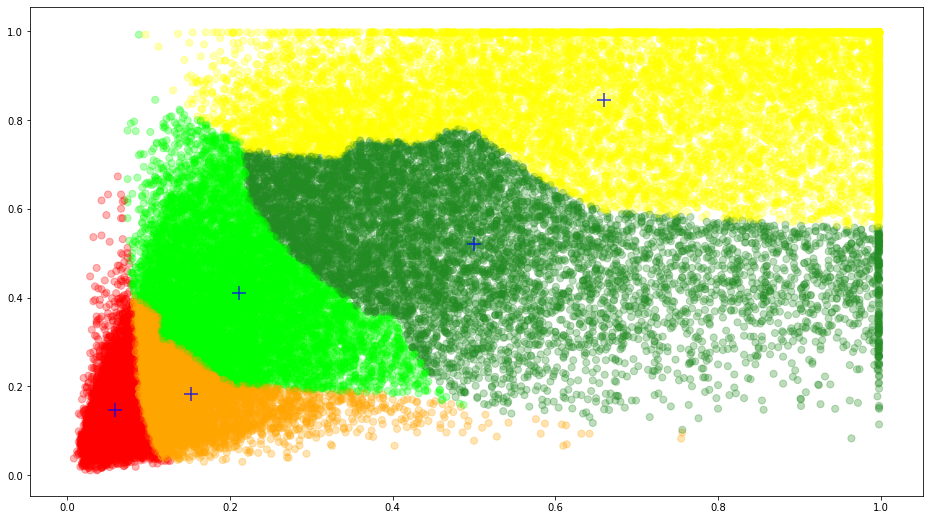

In [31]:
class_list, center_coordinate = kmeans(bboxes, 5, use_alias=True, show=True)

## use numpy choice -- kmeans++

Showing... ...


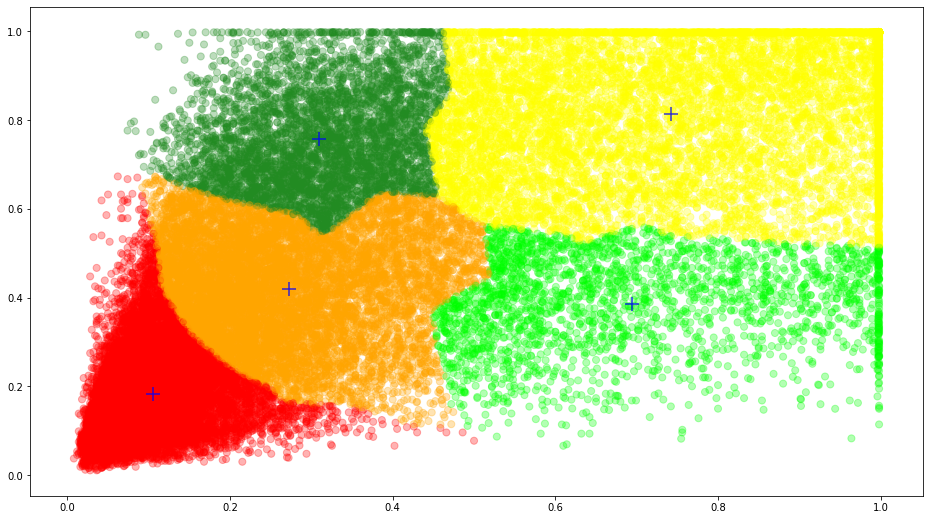

In [32]:
class_list, center_coordinate = kmeans(bboxes, 5, use_alias=True, show=True)

## kmeans

Showing... ...


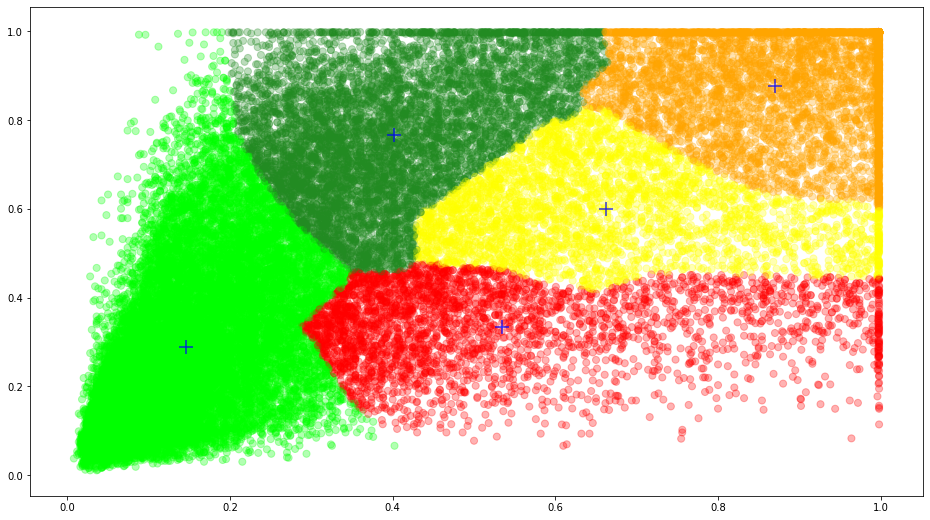

In [33]:
class_list, center_coordinate = kmeans(bboxes, 5, use_alias=False, show=True)

# 计算平均iou

### 每个center与所属同一类别的box计算iou

In [34]:
ious = []

for label, center in enumerate(center_coordinate):
    ious.append(iou(center, bboxes[class_list == label]))

every_class_mean_iou = []
for u in ious:
    every_class_mean_iou.append(np.mean(u))

In [35]:
every_class_mean_iou

[0.6233855445764616,
 0.8170436479285562,
 0.7497798319725723,
 0.41495719322313757,
 0.6996494043671718]

In [36]:
np.mean(every_class_mean_iou)

0.6609631244135799

### 每个center与所有box计算iou

In [37]:
ious = []

for label, center in enumerate(center_coordinate):
    ious.append(iou(center, bboxes))

all_iou = []
for u in ious:
    all_iou.append(np.mean(u))

In [38]:
all_iou

[0.29777484200502113,
 0.2694807872114187,
 0.32225508595139213,
 0.28177547717039714,
 0.34008604235151213]

In [39]:
np.mean(all_iou)

0.30227444693794825

# 取不同k值(5,6,7,8)

In [40]:
def mean_iou(class_list, center_coordinate):
    ious = []
    for label, center in enumerate(center_coordinate):
        ious.append(iou(center, bboxes[class_list == label]))
    every_class_mean_iou = []
    for u in ious:
        every_class_mean_iou.append(np.mean(u))
    return np.mean(every_class_mean_iou)

In [41]:
def plot_ax(k, fig, ax_location, use_alias):
    
    colors = [
          '#FF0000', '#FFA500', '#FFFF00', '#00FF00', '#228B22',
          '#0000FF', '#FF1493', '#EE82EE', '#000000', '#FFA500',
          '#00FF00', '#006400', '#00FFFF', '#0000FF', '#FFFACD',
          ]
    
    class_list, center_coordinate = kmeans(bboxes, k, use_alias=use_alias, show=False)
    use_color = []
    for node in class_list:
        use_color.append(colors[int(node)])
    ax = fig.add_subplot(ax_location)
    ax.scatter(x=bboxes[:, 0], y=bboxes[:, 1], c=use_color, s=30, marker='o', alpha=0.4)
    ax.scatter(x=center_coordinate[:, 0], y=center_coordinate[:, 1], c='b', s=100, marker='+', alpha=0.8)
    ax.set_title('K = %d'%k)
    avg_iou = mean_iou(class_list, center_coordinate)
    ax.legend(title='Mean IOU: %.3f' % avg_iou)

## use alias method -- kmeans++

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


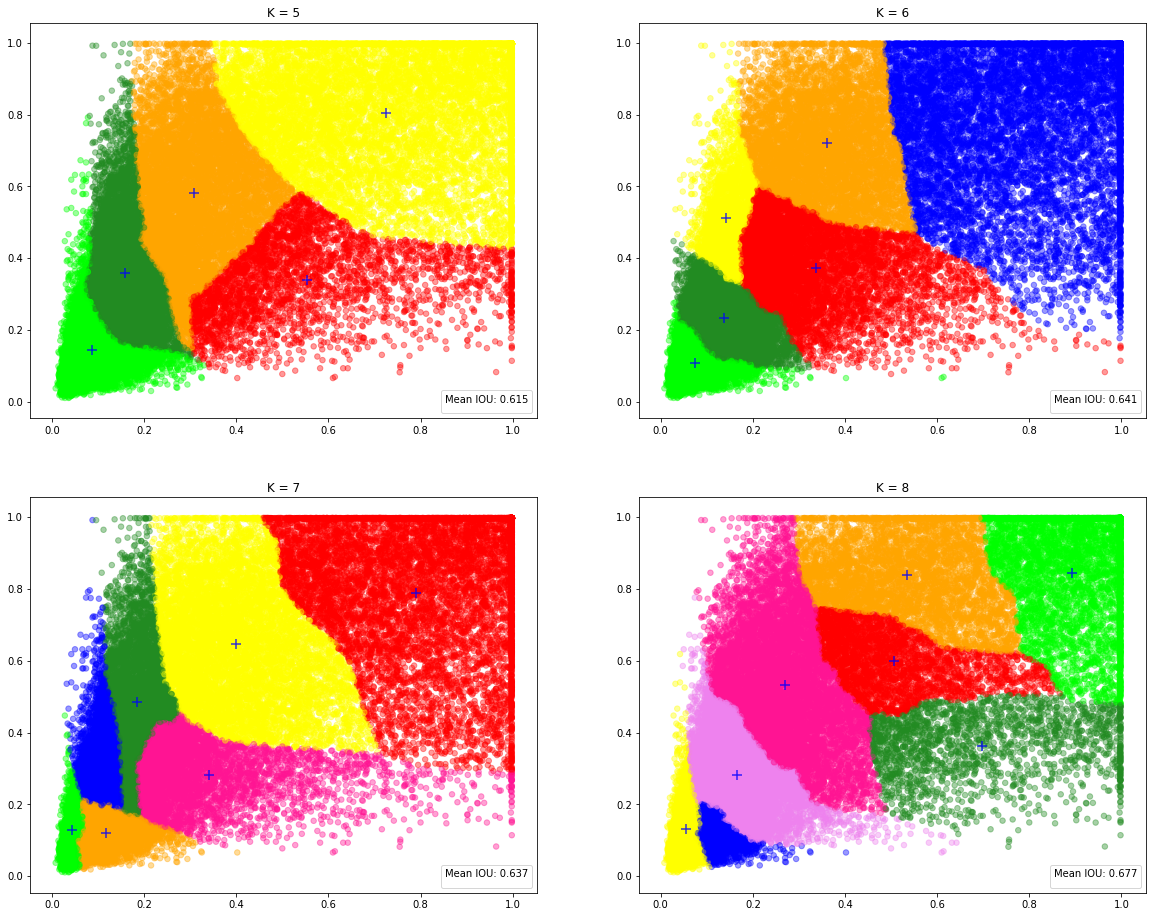

In [45]:
fig = plt.figure(figsize=(20, 16))
plot_ax(k=5, fig=fig, ax_location=221, use_alias=True)
plot_ax(k=6, fig=fig, ax_location=222, use_alias=True)
plot_ax(k=7, fig=fig, ax_location=223, use_alias=True)
plot_ax(k=8, fig=fig, ax_location=224, use_alias=True)
plt.show()

## use numpy choice -- kmeans++

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


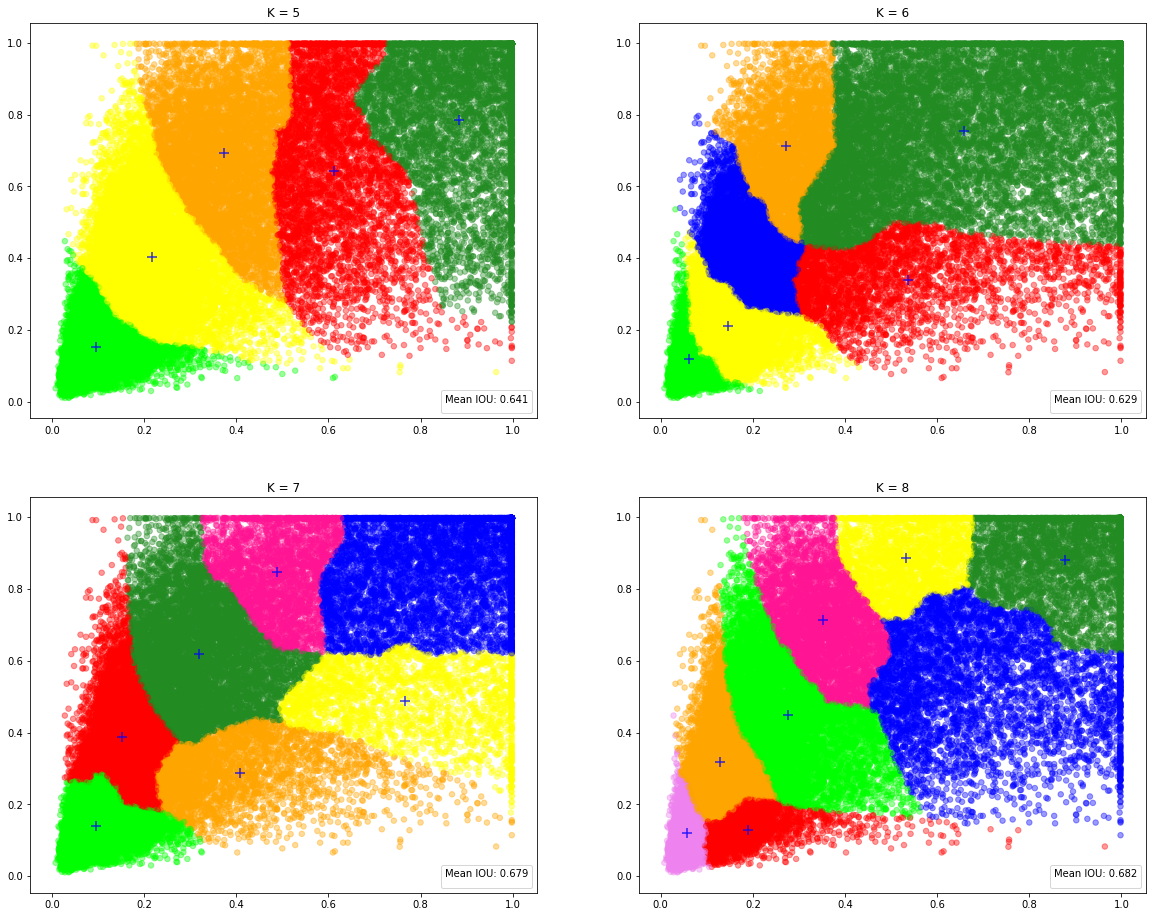

In [43]:
fig = plt.figure(figsize=(20, 16))
plot_ax(k=5, fig=fig, ax_location=221, use_alias=True)
plot_ax(k=6, fig=fig, ax_location=222, use_alias=True)
plot_ax(k=7, fig=fig, ax_location=223, use_alias=True)
plot_ax(k=8, fig=fig, ax_location=224, use_alias=True)
plt.show()

## kmeans

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


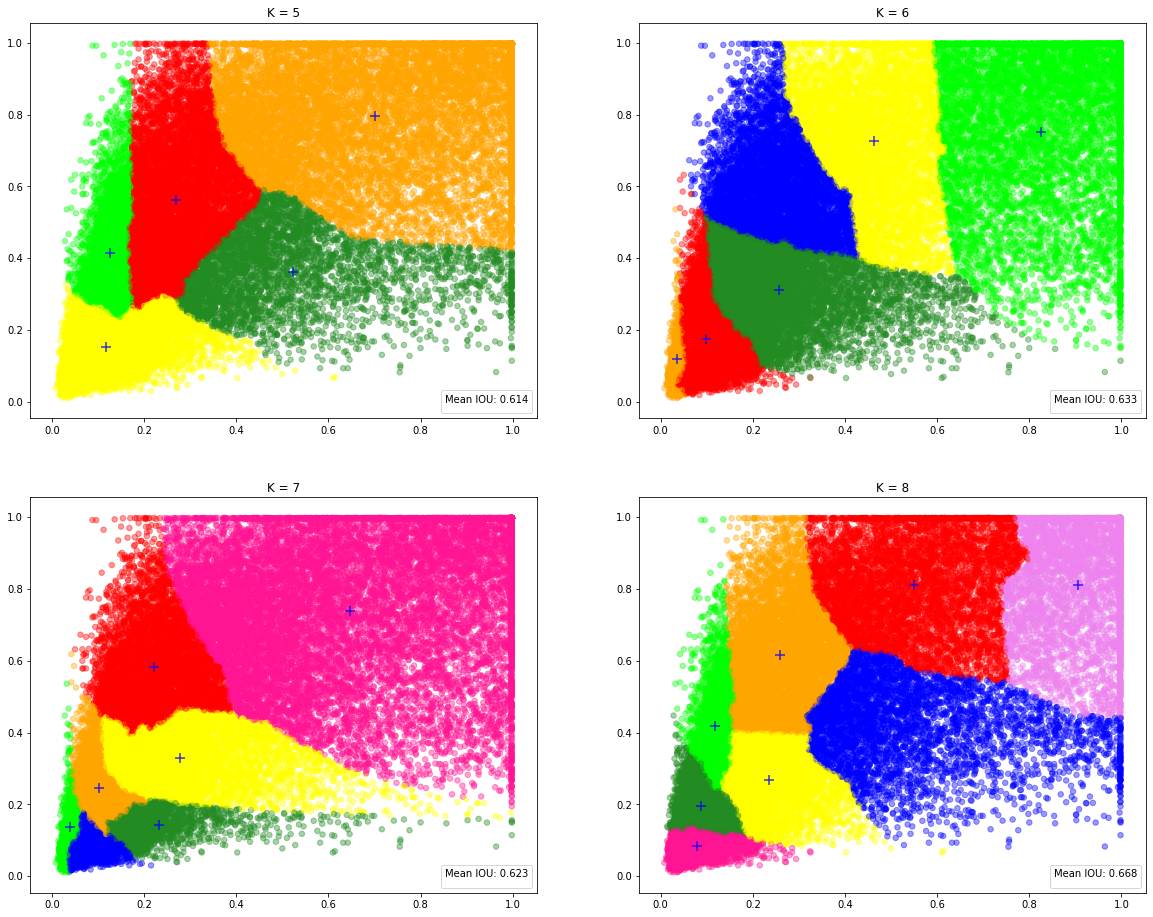

In [44]:
fig = plt.figure(figsize=(20, 16))
plot_ax(k=5, fig=fig, ax_location=221, use_alias=False)
plot_ax(k=6, fig=fig, ax_location=222, use_alias=False)
plot_ax(k=7, fig=fig, ax_location=223, use_alias=False)
plot_ax(k=8, fig=fig, ax_location=224, use_alias=False)
plt.show()